In this notebook, we analyze the BACE enyzme and build machine learning models for predicting the Ki of ligands to the protein. We will use the `deepchem` library to load this data into memory, split into train/test/validation folds, build and cross-validate models, and report statistics.

In [1]:
%load_ext autoreload
%autoreload 2
%pdb off

Automatic pdb calling has been turned OFF


In [3]:
import sys
import deepchem
from deepchem.utils.save import load_from_disk

dataset_file= "../../datasets/desc_canvas_aug30.csv"
dataset = load_from_disk(dataset_file)
num_display=10
pretty_columns = (
    "[" + ",".join(["'%s'" % column for column in dataset.columns.values[:num_display]])
    + ",...]")

crystal_dataset_file = "../../datasets/crystal_desc_canvas_aug30.csv"
crystal_dataset = load_from_disk(crystal_dataset_file)

print("Columns of dataset: %s" % pretty_columns)
print("Number of examples in dataset: %s" % str(dataset.shape[0]))
print("Number of examples in crystal dataset: %s" % str(crystal_dataset.shape[0]))

Columns of dataset: ['mol','CID','Class','Model','pIC50','MW','AlogP','HBA','HBD','RB',...]
Number of examples in dataset: 1522
Number of examples in crystal dataset: 25


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [4]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    imagesList=''.join(
        ["<img style='width: 140px; margin: 0px; float: left; border: 1px solid black;' src='%s' />"
         % str(s) for s in sorted(filenames)])
    display(HTML(imagesList))    

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display a compound from the dataset. Note the complex ring structures and polar structures.

In [5]:
num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="dataset"))

Now let's picture the compounds in the crystal structure collection

In [6]:
num_to_display = 12
molecules = []
for _, data in islice(crystal_dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["mol"]))
display_images(mols_to_pngs(molecules, basename="crystal_dataset"))

Analyzing the distribution of pIC50 values in the dataset gives us a nice spread.

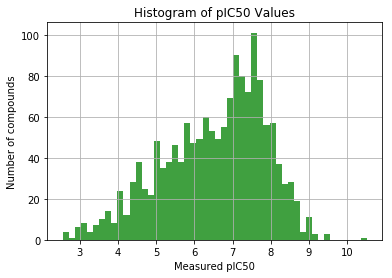

In [7]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

pIC50s = np.array(dataset["pIC50"])
# Remove some dirty data from the dataset
pIC50s = [pIC50 for pIC50 in pIC50s if pIC50 != '']
n, bins, patches = plt.hist(pIC50s, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.show()

We now featurize the data using the Canvas samples. To do so, we must specify the columns in the data input that correspond to the features. (Note that CanvasUID is excluded!)

In [8]:
user_specified_features = ['MW','AlogP','HBA','HBD','RB','HeavyAtomCount','ChiralCenterCount','ChiralCenterCountAllPossible','RingCount','PSA','Estate','MR','Polar','sLi_Key','ssBe_Key','ssssBem_Key','sBH2_Key','ssBH_Key','sssB_Key','ssssBm_Key','sCH3_Key','dCH2_Key','ssCH2_Key','tCH_Key','dsCH_Key','aaCH_Key','sssCH_Key','ddC_Key','tsC_Key','dssC_Key','aasC_Key','aaaC_Key','ssssC_Key','sNH3_Key','sNH2_Key','ssNH2_Key','dNH_Key','ssNH_Key','aaNH_Key','tN_Key','sssNH_Key','dsN_Key','aaN_Key','sssN_Key','ddsN_Key','aasN_Key','ssssN_Key','daaN_Key','sOH_Key','dO_Key','ssO_Key','aaO_Key','aOm_Key','sOm_Key','sF_Key','sSiH3_Key','ssSiH2_Key','sssSiH_Key','ssssSi_Key','sPH2_Key','ssPH_Key','sssP_Key','dsssP_Key','ddsP_Key','sssssP_Key','sSH_Key','dS_Key','ssS_Key','aaS_Key','dssS_Key','ddssS_Key','ssssssS_Key','Sm_Key','sCl_Key','sGeH3_Key','ssGeH2_Key','sssGeH_Key','ssssGe_Key','sAsH2_Key','ssAsH_Key','sssAs_Key','dsssAs_Key','ddsAs_Key','sssssAs_Key','sSeH_Key','dSe_Key','ssSe_Key','aaSe_Key','dssSe_Key','ssssssSe_Key','ddssSe_Key','sBr_Key','sSnH3_Key','ssSnH2_Key','sssSnH_Key','ssssSn_Key','sI_Key','sPbH3_Key','ssPbH2_Key','sssPbH_Key','ssssPb_Key','sLi_Cnt','ssBe_Cnt','ssssBem_Cnt','sBH2_Cnt','ssBH_Cnt','sssB_Cnt','ssssBm_Cnt','sCH3_Cnt','dCH2_Cnt','ssCH2_Cnt','tCH_Cnt','dsCH_Cnt','aaCH_Cnt','sssCH_Cnt','ddC_Cnt','tsC_Cnt','dssC_Cnt','aasC_Cnt','aaaC_Cnt','ssssC_Cnt','sNH3_Cnt','sNH2_Cnt','ssNH2_Cnt','dNH_Cnt','ssNH_Cnt','aaNH_Cnt','tN_Cnt','sssNH_Cnt','dsN_Cnt','aaN_Cnt','sssN_Cnt','ddsN_Cnt','aasN_Cnt','ssssN_Cnt','daaN_Cnt','sOH_Cnt','dO_Cnt','ssO_Cnt','aaO_Cnt','aOm_Cnt','sOm_Cnt','sF_Cnt','sSiH3_Cnt','ssSiH2_Cnt','sssSiH_Cnt','ssssSi_Cnt','sPH2_Cnt','ssPH_Cnt','sssP_Cnt','dsssP_Cnt','ddsP_Cnt','sssssP_Cnt','sSH_Cnt','dS_Cnt','ssS_Cnt','aaS_Cnt','dssS_Cnt','ddssS_Cnt','ssssssS_Cnt','Sm_Cnt','sCl_Cnt','sGeH3_Cnt','ssGeH2_Cnt','sssGeH_Cnt','ssssGe_Cnt','sAsH2_Cnt','ssAsH_Cnt','sssAs_Cnt','dsssAs_Cnt','ddsAs_Cnt','sssssAs_Cnt','sSeH_Cnt','dSe_Cnt','ssSe_Cnt','aaSe_Cnt','dssSe_Cnt','ssssssSe_Cnt','ddssSe_Cnt','sBr_Cnt','sSnH3_Cnt','ssSnH2_Cnt','sssSnH_Cnt','ssssSn_Cnt','sI_Cnt','sPbH3_Cnt','ssPbH2_Cnt','sssPbH_Cnt','ssssPb_Cnt','sLi_Sum','ssBe_Sum','ssssBem_Sum','sBH2_Sum','ssBH_Sum','sssB_Sum','ssssBm_Sum','sCH3_Sum','dCH2_Sum','ssCH2_Sum','tCH_Sum','dsCH_Sum','aaCH_Sum','sssCH_Sum','ddC_Sum','tsC_Sum','dssC_Sum','aasC_Sum','aaaC_Sum','ssssC_Sum','sNH3_Sum','sNH2_Sum','ssNH2_Sum','dNH_Sum','ssNH_Sum','aaNH_Sum','tN_Sum','sssNH_Sum','dsN_Sum','aaN_Sum','sssN_Sum','ddsN_Sum','aasN_Sum','ssssN_Sum','daaN_Sum','sOH_Sum','dO_Sum','ssO_Sum','aaO_Sum','aOm_Sum','sOm_Sum','sF_Sum','sSiH3_Sum','ssSiH2_Sum','sssSiH_Sum','ssssSi_Sum','sPH2_Sum','ssPH_Sum','sssP_Sum','dsssP_Sum','ddsP_Sum','sssssP_Sum','sSH_Sum','dS_Sum','ssS_Sum','aaS_Sum','dssS_Sum','ddssS_Sum','ssssssS_Sum','Sm_Sum','sCl_Sum','sGeH3_Sum','ssGeH2_Sum','sssGeH_Sum','ssssGe_Sum','sAsH2_Sum','ssAsH_Sum','sssAs_Sum','dsssAs_Sum','ddsAs_Sum','sssssAs_Sum','sSeH_Sum','dSe_Sum','ssSe_Sum','aaSe_Sum','dssSe_Sum','ssssssSe_Sum','ddssSe_Sum','sBr_Sum','sSnH3_Sum','ssSnH2_Sum','sssSnH_Sum','ssssSn_Sum','sI_Sum','sPbH3_Sum','ssPbH2_Sum','sssPbH_Sum','ssssPb_Sum','sLi_Avg','ssBe_Avg','ssssBem_Avg','sBH2_Avg','ssBH_Avg','sssB_Avg','ssssBm_Avg','sCH3_Avg','dCH2_Avg','ssCH2_Avg','tCH_Avg','dsCH_Avg','aaCH_Avg','sssCH_Avg','ddC_Avg','tsC_Avg','dssC_Avg','aasC_Avg','aaaC_Avg','ssssC_Avg','sNH3_Avg','sNH2_Avg','ssNH2_Avg','dNH_Avg','ssNH_Avg','aaNH_Avg','tN_Avg','sssNH_Avg','dsN_Avg','aaN_Avg','sssN_Avg','ddsN_Avg','aasN_Avg','ssssN_Avg','daaN_Avg','sOH_Avg','dO_Avg','ssO_Avg','aaO_Avg','aOm_Avg','sOm_Avg','sF_Avg','sSiH3_Avg','ssSiH2_Avg','sssSiH_Avg','ssssSi_Avg','sPH2_Avg','ssPH_Avg','sssP_Avg','dsssP_Avg','ddsP_Avg','sssssP_Avg','sSH_Avg','dS_Avg','ssS_Avg','aaS_Avg','dssS_Avg','ddssS_Avg','ssssssS_Avg','Sm_Avg','sCl_Avg','sGeH3_Avg','ssGeH2_Avg','sssGeH_Avg','ssssGe_Avg','sAsH2_Avg','ssAsH_Avg','sssAs_Avg','dsssAs_Avg','ddsAs_Avg','sssssAs_Avg','sSeH_Avg','dSe_Avg','ssSe_Avg','aaSe_Avg','dssSe_Avg','ssssssSe_Avg','ddssSe_Avg','sBr_Avg','sSnH3_Avg','ssSnH2_Avg','sssSnH_Avg','ssssSn_Avg','sI_Avg','sPbH3_Avg','ssPbH2_Avg','sssPbH_Avg','ssssPb_Avg','First Zagreb (ZM1)','First Zagreb index by valence vertex degrees (ZM1V)','Second Zagreb (ZM2)','Second Zagreb index by valence vertex degrees (ZM2V)','Polarity (Pol)','Narumi Simple Topological (NST)','Narumi Harmonic Topological (NHT)','Narumi Geometric Topological (NGT)','Total structure connectivity (TSC)','Wiener (W)','Mean Wiener (MW)','Xu (Xu)','Quadratic (QIndex)','Radial centric (RC)','Mean Square Distance Balaban (MSDB)','Superpendentic (SP)','Harary (Har)','Log of product of row sums (LPRS)','Pogliani (Pog)','Schultz Molecular Topological (SMT)','Schultz Molecular Topological by valence vertex degrees (SMTV)','Mean Distance Degree Deviation (MDDD)','Ramification (Ram)','Gutman Molecular Topological (GMT)','Gutman MTI by valence vertex degrees (GMTV)','Average vertex distance degree (AVDD)','Unipolarity (UP)','Centralization (CENT)','Variation (VAR)','Molecular electrotopological variation (MEV)','Maximal electrotopological positive variation (MEPV)','Maximal electrotopological negative variation (MENV)','Eccentric connectivity (ECCc)','Eccentricity (ECC)','Average eccentricity (AECC)','Eccentric (DECC)','Valence connectivity index chi-0 (vX0)','Valence connectivity index chi-1 (vX1)','Valence connectivity index chi-2 (vX2)','Valence connectivity index chi-3 (vX3)','Valence connectivity index chi-4 (vX4)','Valence connectivity index chi-5 (vX5)','Average valence connectivity index chi-0 (AvX0)','Average valence connectivity index chi-1 (AvX1)','Average valence connectivity index chi-2 (AvX2)','Average valence connectivity index chi-3 (AvX3)','Average valence connectivity index chi-4 (AvX4)','Average valence connectivity index chi-5 (AvX5)','Quasi Wiener (QW)','First Mohar (FM)','Second Mohar (SM)','Spanning tree number (STN)','Kier benzene-likeliness index (KBLI)','Topological charge index of order 1 (TCI1)','Topological charge index of order 2 (TCI2)','Topological charge index of order 3 (TCI3)','Topological charge index of order 4 (TCI4)','Topological charge index of order 5 (TCI5)','Topological charge index of order 6 (TCI6)','Topological charge index of order 7 (TCI7)','Topological charge index of order 8 (TCI8)','Topological charge index of order 9 (TCI9)','Topological charge index of order 10 (TCI10)','Mean topological charge index of order 1 (MTCI1)','Mean topological charge index of order 2 (MTCI2)','Mean topological charge index of order 3 (MTCI3)','Mean topological charge index of order 4 (MTCI4)','Mean topological charge index of order 5 (MTCI5)','Mean topological charge index of order 6 (MTCI6)','Mean topological charge index of order 7 (MTCI7)','Mean topological charge index of order 8 (MTCI8)','Mean topological charge index of order 9 (MTCI9)','Mean topological charge index of order 10 (MTCI10)','Global topological charge (GTC)','Hyper-distance-path index (HDPI)','Reciprocal hyper-distance-path index (RHDPI)','Square reciprocal distance sum (SRDS)','Modified Randic connectivity (MRC)','Balaban centric (BC)','Lopping centric (LC)','Kier Hall electronegativity (KHE)','Sum of topological distances between N..N (STD(N N))','Sum of topological distances between N..O (STD(N O))','Sum of topological distances between N..S (STD(N S))','Sum of topological distances between N..P (STD(N P))','Sum of topological distances between N..F (STD(N F))','Sum of topological distances between N..Cl (STD(N Cl))','Sum of topological distances between N..Br (STD(N Br))','Sum of topological distances between N..I (STD(N I))','Sum of topological distances between O..O (STD(O O))','Sum of topological distances between O..S (STD(O S))','Sum of topological distances between O..P (STD(O P))','Sum of topological distances between O..F (STD(O F))','Sum of topological distances between O..Cl (STD(O Cl))','Sum of topological distances between O..Br (STD(O Br))','Sum of topological distances between O..I (STD(O I))','Sum of topological distances between S..S (STD(S S))','Sum of topological distances between S..P (STD(S P))','Sum of topological distances between S..F (STD(S F))','Sum of topological distances between S..Cl (STD(S Cl))','Sum of topological distances between S..Br (STD(S Br))','Sum of topological distances between S..I (STD(S I))','Sum of topological distances between P..P (STD(P P))','Sum of topological distances between P..F (STD(P F))','Sum of topological distances between P..Cl (STD(P Cl))','Sum of topological distances between P..Br (STD(P Br))','Sum of topological distances between P..I (STD(P I))','Sum of topological distances between F..F (STD(F F))','Sum of topological distances between F..Cl (STD(F Cl))','Sum of topological distances between F..Br (STD(F Br))','Sum of topological distances between F..I (STD(F I))','Sum of topological distances between Cl..Cl (STD(Cl Cl))','Sum of topological distances between Cl..Br (STD(Cl Br))','Sum of topological distances between Cl..I (STD(Cl I))','Sum of topological distances between Br..Br (STD(Br Br))','Sum of topological distances between Br..I (STD(Br I))','Sum of topological distances between I..I (STD(I I))','Wiener-type index from Z weighted distance matrix - Barysz matrix (WhetZ)','Wiener-type index from electronegativity weighted distance matrix (Whete)','Wiener-type index from mass weighted distance matrix (Whetm)','Wiener-type index from van der waals weighted distance matrix (Whetv)','Wiener-type index from polarizability weighted distance matrix (Whetp)','Balaban-type index from Z weighted distance matrix - Barysz matrix (JhetZ)','Balaban-type index from electronegativity weighted distance matrix (Jhete)','Balaban-type index from mass weighted distance matrix (Jhetm)','Balaban-type index from van der waals weighted distance matrix (Jhetv)','Balaban-type index from polarizability weighted distance matrix (Jhetp)','Topological diameter (TD)','Topological radius (TR)','Petitjean 2D shape (PJ2DS)','Balaban distance connectivity index (J)','Solvation connectivity index chi-0 (SCIX0)','Solvation connectivity index chi-1 (SCIX1)','Solvation connectivity index chi-2 (SCIX2)','Solvation connectivity index chi-3 (SCIX3)','Solvation connectivity index chi-4 (SCIX4)','Solvation connectivity index chi-5 (SCIX5)','Connectivity index chi-0 (CIX0)','Connectivity chi-1 [Randic connectivity] (CIX1)','Connectivity index chi-2 (CIX2)','Connectivity index chi-3 (CIX3)','Connectivity index chi-4 (CIX4)','Connectivity index chi-5 (CIX5)','Average connectivity index chi-0 (ACIX0)','Average connectivity index chi-1 (ACIX1)','Average connectivity index chi-2 (ACIX2)','Average connectivity index chi-3 (ACIX3)','Average connectivity index chi-4 (ACIX4)','Average connectivity index chi-5 (ACIX5)','reciprocal distance Randic-type index (RDR)','reciprocal distance square Randic-type index (RDSR)','1-path Kier alpha-modified shape index (KAMS1)','2-path Kier alpha-modified shape index (KAMS2)','3-path Kier alpha-modified shape index (KAMS3)','Kier flexibility (KF)','path/walk 2 - Randic shape index (RSIpw2)','path/walk 3 - Randic shape index (RSIpw3)','path/walk 4 - Randic shape index (RSIpw4)','path/walk 5 - Randic shape index (RSIpw5)','E-state topological parameter (ETP)','Ring Count 3 (RNGCNT3)','Ring Count 4 (RNGCNT4)','Ring Count 5 (RNGCNT5)','Ring Count 6 (RNGCNT6)','Ring Count 7 (RNGCNT7)','Ring Count 8 (RNGCNT8)','Ring Count 9 (RNGCNT9)','Ring Count 10 (RNGCNT10)','Ring Count 11 (RNGCNT11)','Ring Count 12 (RNGCNT12)','Ring Count 13 (RNGCNT13)','Ring Count 14 (RNGCNT14)','Ring Count 15 (RNGCNT15)','Ring Count 16 (RNGCNT16)','Ring Count 17 (RNGCNT17)','Ring Count 18 (RNGCNT18)','Ring Count 19 (RNGCNT19)','Ring Count 20 (RNGCNT20)','Atom Count (ATMCNT)','Bond Count (BNDCNT)','Atoms in Ring System (ATMRNGCNT)','Bonds in Ring System (BNDRNGCNT)','Cyclomatic number (CYCLONUM)','Number of ring systems (NRS)','Normalized number of ring systems (NNRS)','Ring Fusion degree (RFD)','Ring perimeter (RNGPERM)','Ring bridge count (RNGBDGE)','Molecule cyclized degree (MCD)','Ring Fusion density (RFDELTA)','Ring complexity index (RCI)','Van der Waals surface area (VSA)','MR1 (MR1)','MR2 (MR2)','MR3 (MR3)','MR4 (MR4)','MR5 (MR5)','MR6 (MR6)','MR7 (MR7)','MR8 (MR8)','ALOGP1 (ALOGP1)','ALOGP2 (ALOGP2)','ALOGP3 (ALOGP3)','ALOGP4 (ALOGP4)','ALOGP5 (ALOGP5)','ALOGP6 (ALOGP6)','ALOGP7 (ALOGP7)','ALOGP8 (ALOGP8)','ALOGP9 (ALOGP9)','ALOGP10 (ALOGP10)','PEOE1 (PEOE1)','PEOE2 (PEOE2)','PEOE3 (PEOE3)','PEOE4 (PEOE4)','PEOE5 (PEOE5)','PEOE6 (PEOE6)','PEOE7 (PEOE7)','PEOE8 (PEOE8)','PEOE9 (PEOE9)','PEOE10 (PEOE10)','PEOE11 (PEOE11)','PEOE12 (PEOE12)','PEOE13 (PEOE13)','PEOE14 (PEOE14)']

In [20]:
import deepchem as dc
import tempfile, shutil

featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)
loader = dc.data.UserCSVLoader(
      tasks=["Class"], smiles_field="mol", id_field="mol",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)
crystal_dataset = loader.featurize(crystal_dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../../datasets/desc_canvas_aug30.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.228 s
TIMING: featurizing shard 0 took 0.232 s
TIMING: dataset construction took 0.509 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../../datasets/crystal_desc_canvas_aug30.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.175 s
TIMING: featurizing shard 0 took 0.177 s
TIMING: dataset construction took 0.214 s
Loading dataset from disk.


This data is already split into three subsets "Train" and "Test" with 20% and 80% respectively of the total data from the BACE enzyme. There is also a "Validation" set that contains data from a separate (but related assay). (Note that these names are really misnomers. The "Test" set would be called a validation set in standard machine-learning practice and the "Validation" set would typically be called an external test set.) Hence, we will rename the datasets after loading them.

In [21]:
splitter = dc.splits.SpecifiedSplitter(dataset_file, "Model")
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

TIMING: dataset construction took 0.050 s
Loading dataset from disk.
TIMING: dataset construction took 0.042 s
Loading dataset from disk.
TIMING: dataset construction took 0.124 s
Loading dataset from disk.


Let's quickly take a look at a compound in the validation set. (The compound displayed earlier was drawn from the train set).

In [23]:
print(valid_dataset.ids)
valid_mols = [Chem.MolFromSmiles(compound)
              for compound in islice(valid_dataset.ids, num_to_display)]
display_images(mols_to_pngs(valid_mols, basename="valid_set"))

[ 'S(=O)(=O)(N(C)c1cc(cc(c1)C(=O)NC(C(O)CC(OC)C(=O)NC(C(C)C)C(=O)NCc1ccccc1)COc1cc(F)cc(F)c1)C(=O)NC(C)c1ccccc1)C'
 'O=C(NCCC(C)(C)C)C(Cc1cc2cc(ccc2nc1N)-c1ccccc1C)C'
 'Fc1cc(cc(F)c1)CC(NC(=O)C(N1CCC(NC(=O)C)(C(CC)C)C1=O)CCc1ccccc1)C(O)C1[NH2+]CC(O)C1'
 ..., 'Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1'
 'O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N'
 'Clc1cc2nc(n(c2cc1)CCCC(=O)NCC1CC1)N']


Let's now write these datasets to disk

In [24]:
print("Number of compounds in train set")
print(len(train_dataset))
print("Number of compounds in validation set")
print(len(valid_dataset))
print("Number of compounds in test set")
print(len(test_dataset))
print("Number of compounds in crystal set")
print(len(crystal_dataset))

Number of compounds in train set
204
Number of compounds in validation set
1273
Number of compounds in test set
45
Number of compounds in crystal set
25


The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the pIC50 values (as seen above, the pIC50s range from 2 to 11).

In [27]:
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.ClippingTransformer(transform_X=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset, crystal_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

/home/rbharath/deepchem/deepchem/trans/transformers.py:146: RuntimeWarning: invalid value encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)
/home/rbharath/deepchem/deepchem/trans/transformers.py:146: RuntimeWarning: divide by zero encountered in true_divide
  X = np.nan_to_num((X - self.X_means) / self.X_stds)


TIMING: dataset construction took 0.059 s
Loading dataset from disk.
TIMING: dataset construction took 0.028 s
Loading dataset from disk.
TIMING: dataset construction took 0.194 s
Loading dataset from disk.
TIMING: dataset construction took 0.120 s
Loading dataset from disk.
TIMING: dataset construction took 0.015 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.021 s
Loading dataset from disk.


We now fit simple random forest models to our datasets.

In [33]:
from sklearn.ensemble import RandomForestClassifier

def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestClassifier(**model_params)
  return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/8
hyperparameters: {'n_estimators': 10, 'max_features': 'auto'}
computed_metrics: [0.7355858901719865]
Model 1/8, Metric roc_auc_score, Validation set 0: 0.735586
	best_validation_score so far: 0.735586
Fitting model 2/8
hyperparameters: {'n_estimators': 10, 'max_features': 'sqrt'}
computed_metrics: [0.7159043491812922]
Model 2/8, Metric roc_auc_score, Validation set 1: 0.715904
	best_validation_score so far: 0.735586
Fitting model 3/8
hyperparameters: {'n_estimators': 10, 'max_features': 'log2'}
computed_metrics: [0.75730980187118857]
Model 3/8, Metric roc_auc_score, Validation set 2: 0.757310
	best_validation_score so far: 0.757310
Fitting model 4/8
hyperparameters: {'n_estimators': 10, 'max_features': None}
computed_metrics: [0.76802879177119421]
Model 4/8, Metric roc_auc_score, Validation set 3: 0.768029
	best_validation_score so far: 0.768029
Fitting model 5/8
hyperparameters: {'n_estimators': 100, 'max_features': 'auto'}
computed_metrics: [0.78363061871892459]
Mod

In [51]:
import numpy.random

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
               "nb_epoch": [40] }
n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
  model = dc.models.TensorflowMultiTaskClassifier(
    1, n_features, layer_sizes=[1000], dropouts=[.25],
    batch_size=50, **model_params)
  return model

optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/1
hyperparameters: {'learning_rate': 3.9969728340851975e-05, 'nb_epoch': 40, 'decay': 3.2910674636780646e-05}
Training for 40 epochs
On batch 0
Ending epoch 0: Average loss 3.48682e+08
On batch 0
Ending epoch 1: Average loss 2984.87
On batch 0
Ending epoch 2: Average loss 8.07342e+07
On batch 0
Ending epoch 3: Average loss 7.82307e+06
On batch 0
Ending epoch 4: Average loss 1.275e+08
On batch 0
Ending epoch 5: Average loss 2.4664e+07
On batch 0
Ending epoch 6: Average loss 8.78666e+07
On batch 0
Ending epoch 7: Average loss 7.3558e+07
On batch 0
Ending epoch 8: Average loss 1.67493e+08
On batch 0
Ending epoch 9: Average loss 1.06443e+07
On batch 0
Ending epoch 10: Average loss 6.32065e+07
On batch 0
Ending epoch 11: Average loss 3.46528e+06
On batch 0
Ending epoch 12: Average loss 2.52635e+08
On batch 0
Ending epoch 13: Average loss 4.95842e+07
On batch 0
Ending epoch 14: Average loss 8.2336e+07
On batch 0
Ending epoch 15: Average loss 5.92109e+07
On batch 0
Ending epoc

Now let's evaluate the best model on the validation and test sets and save the results to csv.

In [49]:
from deepchem.utils.evaluate import Evaluator

rf_train_csv_out = "rf_train_regressor.csv"
rf_train_stats_out = "rf_train_stats_regressor.txt"
rf_train_evaluator = Evaluator(best_rf, train_dataset, transformers)
rf_train_score = rf_train_evaluator.compute_model_performance(
    [metric], rf_train_csv_out, rf_train_stats_out)
print("RF Train set AUC %f" % (rf_train_score["roc_auc_score"]))

rf_valid_csv_out = "rf_valid_regressor.csv"
rf_valid_stats_out = "rf_valid_stats_regressor.txt"
rf_valid_evaluator = Evaluator(best_rf, valid_dataset, transformers)
rf_valid_score = rf_valid_evaluator.compute_model_performance(
    [metric], rf_valid_csv_out, rf_valid_stats_out)
print("RF Valid set AUC %f" % (rf_valid_score["roc_auc_score"]))

rf_test_csv_out = "rf_test_regressor.csv"
rf_test_stats_out = "rf_test_stats_regressor.txt"
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_score = rf_test_evaluator.compute_model_performance(
    [metric], rf_test_csv_out, rf_test_stats_out)
print("RF Test set AUC %f" % (rf_test_score["roc_auc_score"]))

rf_crystal_csv_out = "rf_crystal_regressor.csv"
rf_crystal_stats_out = "rf_crystal_stats_regressor.txt"
rf_crystal_evaluator = Evaluator(best_rf, crystal_dataset, transformers)
rf_crystal_score = rf_crystal_evaluator.compute_model_performance(
    [metric], rf_crystal_csv_out, rf_crystal_stats_out)
print("RF Crystal set R^2 %f" % (rf_crystal_score["roc_auc_score"]))

computed_metrics: [0.99980776624375234]
RF Train set AUC 0.999808
computed_metrics: [0.7923505990116182]
RF Valid set AUC 0.792351
computed_metrics: [0.59090909090909094]
RF Test set AUC 0.590909
computed_metrics: [nan]
RF Crystal set R^2 nan


/home/rbharath/deepchem/deepchem/metrics/__init__.py:297: UserWarning: Error calculating metric roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))


In [56]:
dnn_train_csv_out = "dnn_train_classifier.csv"
dnn_train_stats_out = "dnn_train_classifier_stats.txt"
dnn_train_evaluator = Evaluator(best_dnn, train_dataset, transformers)
dnn_train_score = dnn_train_evaluator.compute_model_performance(
    [metric], dnn_train_csv_out, dnn_train_stats_out)
print("DNN Train set AUC %f" % (dnn_train_score["roc_auc_score"]))

dnn_valid_csv_out = "dnn_valid_classifier.csv"
dnn_valid_stats_out = "dnn_valid_classifier_stats.txt"
dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, transformers)
dnn_valid_score = dnn_valid_evaluator.compute_model_performance(
    [metric], dnn_valid_csv_out, dnn_valid_stats_out)
print("DNN Valid set AUC %f" % (dnn_valid_score["roc_auc_score"]))

dnn_test_csv_out = "dnn_test_classifier.csv"
dnn_test_stats_out = "dnn_test_classifier_stats.txt"
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
dnn_test_score = dnn_test_evaluator.compute_model_performance(
    [metric], dnn_test_csv_out, dnn_test_stats_out)
print("DNN Test set AUC %f" % (dnn_test_score["roc_auc_score"]))

dnn_crystal_csv_out = "dnn_crystal_classifier.csv"
dnn_crystal_stats_out = "dnn_crystal_stats_classifier.txt"
dnn_crystal_evaluator = Evaluator(best_dnn, crystal_dataset, transformers)
dnn_crystal_score = dnn_crystal_evaluator.compute_model_performance(
    [metric], dnn_crystal_csv_out, dnn_crystal_stats_out)
print("DNN Crystal set AUC %f" % (dnn_crystal_score["roc_auc_score"]))

computed_metrics: [0.77732122260668968]
DNN Train set AUC 0.777321
computed_metrics: [0.66898952295247627]
DNN Valid set AUC 0.668990
computed_metrics: [0.36363636363636365]
DNN Test set AUC 0.363636
computed_metrics: [nan]
DNN Crystal set AUC nan


Now, we construct regression models for the data.

In [57]:
#Make directories to store the raw and featurized datasets.
featurizer = dc.feat.UserDefinedFeaturizer(user_specified_features)
loader = dc.data.UserCSVLoader(
    tasks=["pIC50"], smiles_field="mol", id_field="CID",
    featurizer=featurizer)
dataset = loader.featurize(dataset_file)
crystal_dataset = loader.featurize(crystal_dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../../datasets/desc_canvas_aug30.csv
Loading shard 1 of size 8192.
TIMING: user specified processing took 0.232 s
TIMING: featurizing shard 0 took 0.240 s
TIMING: dataset construction took 0.513 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../../datasets/crystal_desc_canvas_aug30.csv
Loading shard 1 of size 8192.


/home/rbharath/deepchem/deepchem/data/data_loader.py:42: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if y[ind, task] == "":


TIMING: user specified processing took 0.200 s
TIMING: featurizing shard 0 took 0.200 s
TIMING: dataset construction took 0.244 s
Loading dataset from disk.


In [58]:
splitter = dc.splits.SpecifiedSplitter(dataset_file, "Model")
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

TIMING: dataset construction took 0.060 s
Loading dataset from disk.
TIMING: dataset construction took 0.047 s
Loading dataset from disk.
TIMING: dataset construction took 0.143 s
Loading dataset from disk.


In [59]:
print("Number of compounds in train set")
print(len(train_dataset))
print("Number of compounds in validation set")
print(len(valid_dataset))
print("Number of compounds in test set")
print(len(test_dataset))
print("Number of compounds in crystal set")
print(len(crystal_dataset))

Number of compounds in train set
204
Number of compounds in validation set
1273
Number of compounds in test set
45
Number of compounds in crystal set
25


In [60]:
transformers = [
    dc.trans.NormalizationTransformer(transform_X=True, dataset=train_dataset),
    dc.trans.ClippingTransformer(transform_X=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset, crystal_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.034 s
Loading dataset from disk.
TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 0.177 s
Loading dataset from disk.
TIMING: dataset construction took 0.126 s
Loading dataset from disk.
TIMING: dataset construction took 0.009 s
Loading dataset from disk.
TIMING: dataset construction took 0.019 s
Loading dataset from disk.
TIMING: dataset construction took 0.017 s
Loading dataset from disk.
TIMING: dataset construction took 0.016 s
Loading dataset from disk.


In [61]:
from sklearn.ensemble import RandomForestRegressor

def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestRegressor(**model_params)
  return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/8
hyperparameters: {'n_estimators': 10, 'max_features': 'auto'}
computed_metrics: [0.15535846258941899]
Model 1/8, Metric r2_score, Validation set 0: 0.155358
	best_validation_score so far: 0.155358
Fitting model 2/8
hyperparameters: {'n_estimators': 10, 'max_features': 'sqrt'}
computed_metrics: [0.19331662987064735]
Model 2/8, Metric r2_score, Validation set 1: 0.193317
	best_validation_score so far: 0.193317
Fitting model 3/8
hyperparameters: {'n_estimators': 10, 'max_features': 'log2'}
computed_metrics: [0.17874997305651175]
Model 3/8, Metric r2_score, Validation set 2: 0.178750
	best_validation_score so far: 0.193317
Fitting model 4/8
hyperparameters: {'n_estimators': 10, 'max_features': None}
computed_metrics: [0.26373741744226398]
Model 4/8, Metric r2_score, Validation set 3: 0.263737
	best_validation_score so far: 0.263737
Fitting model 5/8
hyperparameters: {'n_estimators': 100, 'max_features': 'auto'}
computed_metrics: [0.25361003559580186]
Model 5/8, Metric r2_

In [63]:
import numpy.random

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=2)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=2)),
               "nb_epoch": [20] }
n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
  model = dc.models.TensorflowMultiTaskRegressor(
    1, n_features, layer_sizes=[1000], dropouts=[.25],
    batch_size=50, **model_params)
  return model

optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/4
hyperparameters: {'learning_rate': 0.00055757754102415166, 'nb_epoch': 20, 'decay': 1.5192138202879355e-06}
Training for 20 epochs
On batch 0
Ending epoch 0: Average loss nan
On batch 0
Ending epoch 1: Average loss nan
On batch 0
Ending epoch 2: Average loss nan
On batch 0
Ending epoch 3: Average loss nan
On batch 0
Ending epoch 4: Average loss nan
On batch 0
Ending epoch 5: Average loss nan
On batch 0
Ending epoch 6: Average loss nan
On batch 0
Ending epoch 7: Average loss nan
On batch 0
Ending epoch 8: Average loss nan
On batch 0
Ending epoch 9: Average loss nan
On batch 0
Ending epoch 10: Average loss nan
On batch 0
Ending epoch 11: Average loss nan
On batch 0
Ending epoch 12: Average loss nan
On batch 0
Ending epoch 13: Average loss nan
On batch 0
Ending epoch 14: Average loss nan
On batch 0
Ending epoch 15: Average loss nan
On batch 0
Ending epoch 16: Average loss nan
On batch 0
Ending epoch 17: Average loss nan
On batch 0
Ending epoch 18: Average loss nan
On bat

In [64]:
from deepchem.utils.evaluate import Evaluator

rf_train_csv_out = "rf_train_regressor.csv"
rf_train_stats_out = "rf_train_stats_regressor.txt"
rf_train_evaluator = Evaluator(best_rf, train_dataset, transformers)
rf_train_score = rf_train_evaluator.compute_model_performance(
    [metric], rf_train_csv_out, rf_train_stats_out)
print("RF Train set R^2 %f" % (rf_train_score["r2_score"]))

rf_valid_csv_out = "rf_valid_regressor.csv"
rf_valid_stats_out = "rf_valid_stats_regressor.txt"
rf_valid_evaluator = Evaluator(best_rf, valid_dataset, transformers)
rf_valid_score = rf_valid_evaluator.compute_model_performance(
    [metric], rf_valid_csv_out, rf_valid_stats_out)
print("RF Valid set R^2 %f" % (rf_valid_score["r2_score"]))

rf_test_csv_out = "rf_test_regressor.csv"
rf_test_stats_out = "rf_test_stats_regressor.txt"
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_score = rf_test_evaluator.compute_model_performance(
    [metric], rf_test_csv_out, rf_test_stats_out)
print("RF Test set R^2 %f" % (rf_test_score["r2_score"]))

rf_crystal_csv_out = "rf_crystal_regressor.csv"
rf_crystal_stats_out = "rf_crystal_stats_regressor.txt"
rf_crystal_evaluator = Evaluator(best_rf, crystal_dataset, transformers)
rf_crystal_score = rf_crystal_evaluator.compute_model_performance(
    [metric], rf_crystal_csv_out, rf_crystal_stats_out)
print("RF Crystal set R^2 %f" % (rf_crystal_score["r2_score"]))

computed_metrics: [0.92319598282890769]
RF Train set R^2 0.923196
computed_metrics: [0.26373741744226398]
RF Valid set R^2 0.263737
computed_metrics: [0.46527610391640728]
RF Test set R^2 0.465276
computed_metrics: [nan]
RF Crystal set R^2 nan


In [65]:
dnn_train_csv_out = "dnn_train_regressor.csv"
dnn_train_stats_out = "dnn_train_regressor_stats.txt"
dnn_train_evaluator = Evaluator(best_dnn, train_dataset, transformers)
dnn_train_score = dnn_train_evaluator.compute_model_performance(
    [metric], dnn_train_csv_out, dnn_train_stats_out)
print("DNN Train set R^2 %f" % (dnn_train_score["r2_score"]))

dnn_valid_csv_out = "dnn_valid_regressor.csv"
dnn_valid_stats_out = "dnn_valid_regressor_stats.txt"
dnn_valid_evaluator = Evaluator(best_dnn, valid_dataset, transformers)
dnn_valid_score = dnn_valid_evaluator.compute_model_performance(
    [metric], dnn_valid_csv_out, dnn_valid_stats_out)
print("DNN Valid set R^2 %f" % (dnn_valid_score["r2_score"]))

dnn_test_csv_out = "dnn_test_regressor.csv"
dnn_test_stats_out = "dnn_test_regressor_stats.txt"
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
dnn_test_score = dnn_test_evaluator.compute_model_performance(
    [metric], dnn_test_csv_out, dnn_test_stats_out)
print("DNN Test set R^2 %f" % (dnn_test_score["r2_score"]))

dnn_crystal_csv_out = "dnn_crystal_regressor.csv"
dnn_crystal_stats_out = "dnn_crystal_stats_regressor.txt"
dnn_crystal_evaluator = Evaluator(best_dnn, crystal_dataset, transformers)
dnn_crystal_score = dnn_crystal_evaluator.compute_model_performance(
    [metric], dnn_crystal_csv_out, dnn_crystal_stats_out)
print("DNN Crystal set R^2 %f" % (dnn_crystal_score["r2_score"]))


computed_metrics: [nan]
DNN Train set R^2 nan
computed_metrics: [nan]
DNN Valid set R^2 nan
computed_metrics: [nan]
DNN Test set R^2 nan
computed_metrics: [nan]
DNN Crystal set R^2 nan


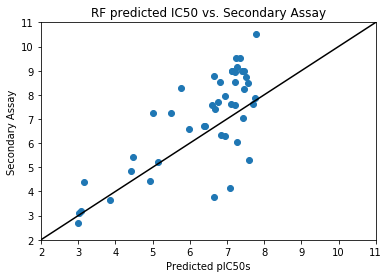

In [66]:
task = "pIC50"
rf_predicted_test = best_rf.predict(test_dataset)
rf_true_test = test_dataset.y
plt.scatter(rf_predicted_test, rf_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'RF predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

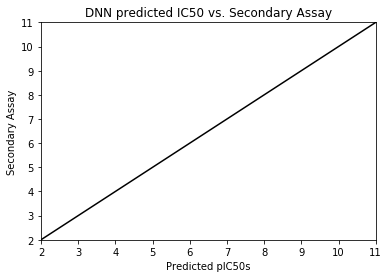

In [67]:
task = "pIC50"
dnn_predicted_test = best_dnn.predict(test_dataset)
dnn_true_test = test_dataset.y
plt.scatter(dnn_predicted_test, dnn_true_test)
plt.xlabel('Predicted pIC50s')
plt.ylabel('Secondary Assay')
plt.title(r'DNN predicted IC50 vs. Secondary Assay')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()